# Tello Vision Telemetry Lab

## 2D Motion Reconstruction

### Description: 2D Person Localization in Drone IMU Odometry tracks

See data explanation at [the end of the notebook](#data-explanation).

### Index:
* [Telemetry Analysis Setup](#analysis-setup)
* [Tracking Mode Analysis](#trackMode-analysis)
* [Detected Person 2D Localization referred to IMU Odometry track (filtered by trackMode)](#trackMode-plots)
* [Select a trackMode to Animate](#trackMode-selection)
* [2D Animation: Drone IMU Odometry Track and Person Localization](#trackMode-selection)
* [Telemetry Data Explanation](#data-explanation)
* [Telemetry Data Filtering](#data-filtering)

### Telemetry Analysis Setup <a class="anchor" id="analysis-setup"></a>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [6]:
#Read data
df = pd.read_csv('data/tv_telemetry_210327_131735_isonzo_party.txt',decimal=".")
df.tail(2)

,timestamp,trackMode,telSeqId,personCount,personConfidence,faceXPx,faceYPx,faceRadiusPx,angle_err,estimatedDistance,...,Uy,pitch,roll,yaw,vx,vy,vz,tof,batt,temp
3927,415636,0,3,0,61,845,127,0,26,224,...,0,7,0,120,0,0,0,10,11,68
3928,415736,0,3,0,61,845,127,0,26,224,...,0,7,0,120,0,0,0,10,11,68


In [11]:
#Extract data columns
timestamp=df["timestamp"]
trackMode=df["trackMode"]
telSeqId=df["telSeqId"]
personCount=df["personCount"]
personConfidence=df["personConfidence"]
faceXPx=df["faceXPx"]
faceYPx=df["faceYPx"]
faceRadius=df["faceRadiusPx"]
theta=df["angle_err"]
estimatedDistance=df["estimatedDistance"]
yPos=df["estimatedYPos"]
Uyaw=df["Uyaw"]
Ux=df["Ux"]
Uy=df["Ux"]
Uz=df["Uz"]
pitch=df["pitch"]
roll=df["roll"]
yaw=df["yaw"]
vx=df["vx"]
vy=df["vy"]
vz=df["vz"]
tof=df["tof"]
batt=df["batt"]
temp=df["temp"]

In [25]:
#Figures dpi
dpiSelected=72

## Tracking mode analysis <a class="anchor" id="trackMode-analysis"></a>

<IPython.core.display.Javascript object>


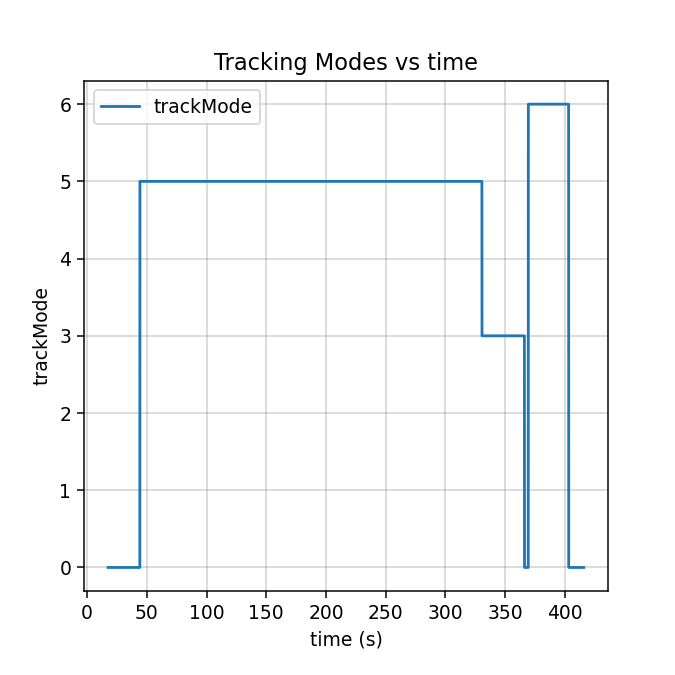

In [9]:
%matplotlib notebook
plt.figure(figsize=(5,5))
plt.plot(timestamp/1000,trackMode)
plt.ylabel('trackMode')
plt.xlabel('time (s)')
plt.title('Tracking Modes vs time')
plt.legend(['trackMode'],loc='upper left')
plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.grid(b=True, which='minor', color='#666666', linestyle='-',alpha=0.3)
plt.savefig("out/jpg/2d-motion-reconstruction/trackMode-time",dpi=dpiSelected)
plt.show()

In [10]:
N=len(timestamp)
tstart=timestamp.iloc[0]/1000
tend=timestamp.iloc[-1]/1000
tduration=tend-tstart
atstep=tduration/(N-1)
print("Data points: {:.0f} ".format(N))
print("Time start: {:.3f} s".format(tstart))
print("Time end: {:.3f} s".format(tend))
print("Duration: {:.3f} s".format(tduration))
print("Avg timestep: {:.3f} s".format(atstep))
print("Avg freq: {:.2f} Hz ".format(1/atstep))

Data points: 3929 
Time start: 17.677 s
Time end: 415.736 s
Duration: 398.059 s
Avg timestep: 0.101 s
Avg freq: 9.87 Hz 


## Tracking mode selection <a class="anchor" id="trackMode-selection"></a>

In [14]:
#Select tracking Mode to display
# 0 -> None
# 1 -> Spotlight
# 2 -> Follow
# 3 -> Orbit
# 4 -> Profile
# 5 -> Party
# 6 -> Go forward with Person Avoidance

#Choose trackMode code
trackModeCode=5
dataSelector=(trackMode==trackModeCode)
print(trackMode.value_counts())
if(len(trackMode[dataSelector])>0):
    print("\ntrackMode {:d} has {:d}/{:d} data in current telemetry file".format(trackModeCode,len(trackMode[dataSelector]),len(trackMode)))
else:
    print("\ntrackMode {:d} not present in current telemetry file".format(trackModeCode))


5    2825
0     420
3     351
6     333
Name: trackMode, dtype: int64

trackMode 5 has 2825/3929 data in current telemetry file


### Detected Person 2D Localization referred to IMU Odometry track (filtered by trackMode) <a class="anchor" id="trackMode-plots"></a>

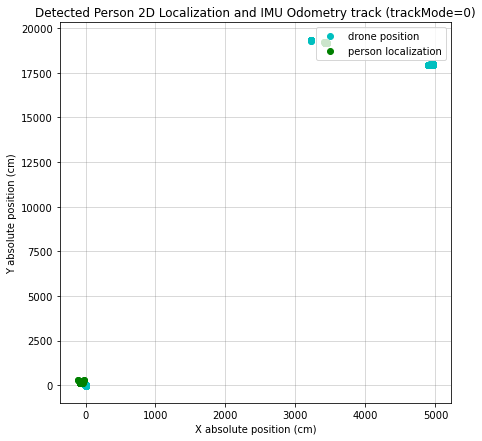

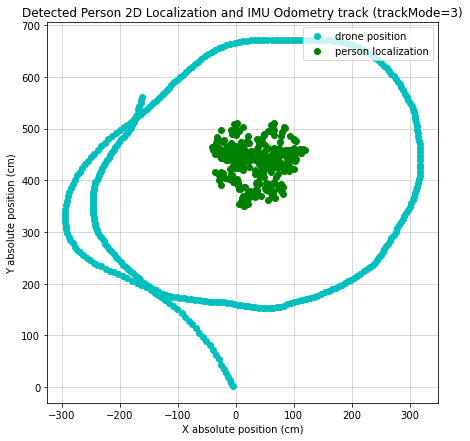

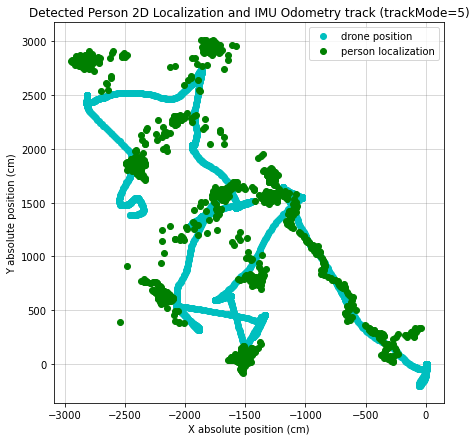

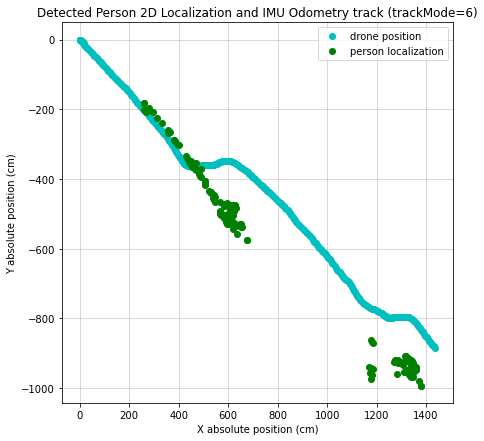

In [16]:
%matplotlib inline

for k in range(7):
    #Cycle all trackMode modes from 0 to 6 present in the telemetry
    modePresent=(trackMode==k)
    if(modePresent.any()):
        #IMU odometry calculation
        timeS=(timestamp[trackMode==k])/1000
        vxSeq=vx[trackMode==k]
        vySeq=vy[trackMode==k]
        deltaTimeS=np.diff(timeS)
        #drone and camera absolute position and pose
        distanceXSeq=np.cumsum(10*vySeq[1:len(vySeq)]*deltaTimeS)
        distanceYSeq=np.cumsum(10*vxSeq[1:len(vxSeq)]*deltaTimeS)
        yawSeq=yaw[trackMode==k]
        
       
        cameraXSeq=distanceXSeq+10*np.sin((yawSeq[1:len(yawSeq)])*np.pi/180)
        cameraYSeq=distanceYSeq+10*np.cos((yawSeq[1:len(yawSeq)])*np.pi/180)
        
        thetaDetf=(theta[(trackMode==k)&(personCount>0)])
        yawDetf=(yaw[(trackMode==k)&(personCount>0)])
        estimatedDistanceDetf=(estimatedDistance[(trackMode==k)&(personCount>0)])
        
        toff=(tof[trackMode==k])
        yPosf=(yPos[(trackMode==k)&(personCount>0)])

        xPersonRel = estimatedDistanceDetf*np.cos((90-yawDetf-thetaDetf)*np.pi/180) 
        yPersonRel = estimatedDistanceDetf*np.sin((90-yawDetf-thetaDetf)*np.pi/180) 
        
        xPersonAbs = distanceXSeq[personCount>0] + xPersonRel[0:-1]
        yPersonAbs = distanceYSeq[personCount>0] + yPersonRel[0:-1]
        plt.figure(figsize=(7,7))
        plt.plot(distanceXSeq,distanceYSeq,'co')
        plt.plot(xPersonAbs,yPersonAbs,'go')
        plt.xlabel('X absolute position (cm)')
        plt.ylabel('Y absolute position (cm)')
        plt.title('Detected Person 2D Localization and IMU Odometry track (trackMode={:d})'.format(k))
        plt.legend(['drone position','person localization'],loc='upper right')
        plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
        plt.grid(b=True, which='minor', color='#666666', linestyle='-',alpha=0.3)
        plt.savefig("out/jpg/2d-motion-reconstruction/2d-motion-reconstruction-trackMode-{:d}.jpg".format(k),dpi=dpiSelected)


plt.show()

### Select a trackMode to Animate <a class="anchor" id="trackMode-selection"></a>

In [21]:
#trackModeCode=3
selectedTrackMode=3

### 2D Animation: Drone IMU Odometry Track and Person Localization <a class="anchor" id="trackMode-animation"></a>

<IPython.core.display.Javascript object>


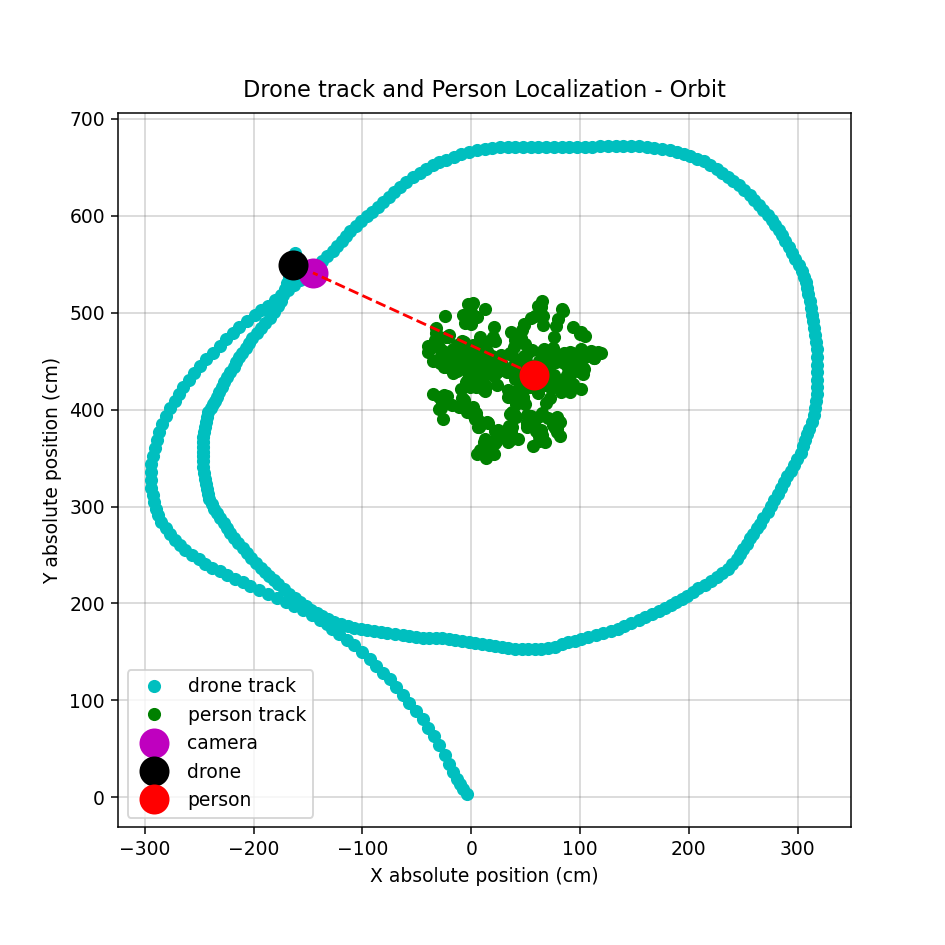

In [23]:
%matplotlib notebook
k=selectedTrackMode

modePresent=(trackMode==k)
if(modePresent.any()):
    #IMU odometry calculation
    timeS=(timestamp[trackMode==k])/1000
    vxSeq=vx[trackMode==k]
    vySeq=vy[trackMode==k]
    deltaTimeS=np.diff(timeS)
    #drone and camera absolute position and pose
    distanceXSeq=np.cumsum(10*vySeq[1:len(vySeq)]*deltaTimeS)
    distanceYSeq=np.cumsum(10*vxSeq[1:len(vxSeq)]*deltaTimeS)
    yawSeq=yaw[trackMode==k]
    personCountSeq=(personCount[trackMode==k])
        
    cameraXSeq=distanceXSeq+20*np.sin((yawSeq[1:len(yawSeq)])*np.pi/180)
    cameraYSeq=distanceYSeq+20*np.cos((yawSeq[1:len(yawSeq)])*np.pi/180)
        
    thetaDetf=(theta[(trackMode==k)&(personCount>0)])
    yawDetf=(yaw[(trackMode==k)&(personCount>0)])
    estimatedDistanceDetf=(estimatedDistance[(trackMode==k)&(personCount>0)])
        
    toff=(tof[trackMode==k])
    yPosf=(yPos[(trackMode==k)&(personCount>0)])

    xPersonRel = estimatedDistanceDetf*np.cos((90-yawDetf-thetaDetf)*np.pi/180) 
    yPersonRel = estimatedDistanceDetf*np.sin((90-yawDetf-thetaDetf)*np.pi/180) 
    
    xPersonAbs = distanceXSeq[personCount>0] + xPersonRel[1:-1]
    yPersonAbs = distanceYSeq[personCount>0] + yPersonRel[1:-1]

    fig7 = plt.figure(figsize=(7,7))
    ax = fig7.add_subplot(111)


    def draw_data5(i):       
        # Clear
        ax.cla()
        #Drone complete track
        plt.plot(distanceXSeq,distanceYSeq,'co')
        #Person complete track
        plt.plot(xPersonAbs[personCount>0],yPersonAbs[personCount>0],'go')
        #Camera current position (drone orientation)
        plt.plot(cameraXSeq[i:i+1],cameraYSeq[i:i+1],'mo',ms='15')
        #Drone current position
        plt.plot(distanceXSeq[i:i+1],distanceYSeq[i:i+1],'ko',ms='15')
        
        #Person current position (if present)
        id=distanceXSeq[i:i+1].index.values.astype(int)[0]
        if(id in xPersonAbs.index.values):
            plt.plot(xPersonAbs.loc[id],yPersonAbs[id],'ro',ms='15')
            #Camera-Person line of sigth
            plt.plot([xPersonAbs.loc[id],cameraXSeq.loc[id]],[yPersonAbs.loc[id],cameraYSeq.loc[id]],'r--',ms='1')

        
        axMax=np.max([np.max(distanceXSeq),np.max(distanceYSeq),np.max(xPersonAbs),np.max(yPersonAbs)])    
        axMin=np.min([np.min(distanceXSeq),np.min(distanceYSeq),np.min(xPersonAbs),np.min(yPersonAbs)])    
        
        #axMax=2500
        #ax.set_xlim(axMin,axMax)
        #ax.set_ylim(axMin,axMax)
        
    
        ax.set_title("Drone track and Person Localization - Orbit", va='bottom')
        ax.legend(['drone track','person track','camera','drone','person'],loc='lower left')
        plt.xlabel('X absolute position (cm)')
        plt.ylabel('Y absolute position (cm)')
        plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
        plt.grid(b=True, which='minor', color='#666666', linestyle='-',alpha=0.3)
    


    anim = animation.FuncAnimation(fig7, draw_data5, interval=10, frames=len(distanceXSeq)-2, repeat=False)    
    plt.show()
    
else:     
    print("Tracking mode {:d} is not present in this telemetry data!".format(k))
   
    

<IPython.core.display.Javascript object>


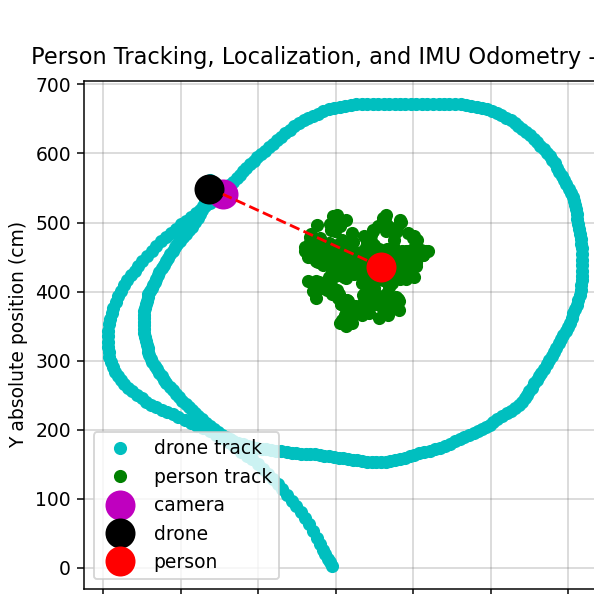

In [24]:
%matplotlib notebook
k=selectedTrackMode
modePresent=(trackMode==k)
if(modePresent.any()):
    #IMU odometry calculation
    timeS=(timestamp[trackMode==k])/1000
    vxSeq=vx[trackMode==k]
    vySeq=vy[trackMode==k]
    deltaTimeS=np.diff(timeS)
    #drone and camera absolute position and pose
    distanceXSeq=np.cumsum(10*vySeq[1:len(vySeq)]*deltaTimeS)
    distanceYSeq=np.cumsum(10*vxSeq[1:len(vxSeq)]*deltaTimeS)
    yawSeq=yaw[trackMode==k]
    personCountSeq=(personCount[trackMode==k])
        
    cameraXSeq=distanceXSeq+20*np.sin((yawSeq[1:len(yawSeq)])*np.pi/180)
    cameraYSeq=distanceYSeq+20*np.cos((yawSeq[1:len(yawSeq)])*np.pi/180)
        
    thetaDetf=(theta[(trackMode==k)&(personCount>0)])
    yawDetf=(yaw[(trackMode==k)&(personCount>0)])
    estimatedDistanceDetf=(estimatedDistance[(trackMode==k)&(personCount>0)])
        
    toff=(tof[trackMode==k])
    yPosf=(yPos[(trackMode==k)&(personCount>0)])

    xPersonRel = estimatedDistanceDetf*np.cos((90-yawDetf-thetaDetf)*np.pi/180) 
    yPersonRel = estimatedDistanceDetf*np.sin((90-yawDetf-thetaDetf)*np.pi/180) 
    
    xPersonAbs = distanceXSeq[personCount>0] + xPersonRel[1:-1]
    yPersonAbs = distanceYSeq[personCount>0] + yPersonRel[1:-1]

    fig7 = plt.figure(figsize=(5,5))
    ax = fig7.add_subplot(111)


    def draw_data5(i):       
        # Clear
        ax.cla()
        #Drone complete track
        plt.plot(distanceXSeq,distanceYSeq,'co')
        #Person complete track
        plt.plot(xPersonAbs[personCount>0],yPersonAbs[personCount>0],'go')
        #Camera current position (drone orientation)
        plt.plot(cameraXSeq[i:i+1],cameraYSeq[i:i+1],'mo',ms='15')
        #Drone current position
        plt.plot(distanceXSeq[i:i+1],distanceYSeq[i:i+1],'ko',ms='15')
        
        id=distanceXSeq[i:i+1].index.values.astype(int)[0]
        if(id in xPersonAbs.index.values):
            plt.plot(xPersonAbs.loc[id],yPersonAbs[id],'ro',ms='15')
            #Camera-Person line of sigth
            plt.plot([xPersonAbs.loc[id],cameraXSeq.loc[id]],[yPersonAbs.loc[id],cameraYSeq.loc[id]],'r--',ms='1')
            
        axMax=np.max([np.max(distanceXSeq),np.max(distanceYSeq),np.max(xPersonAbs),np.max(yPersonAbs)])    
        axMin=np.min([np.min(distanceXSeq),np.min(distanceYSeq),np.min(xPersonAbs),np.min(yPersonAbs)])    

        #ax.set_xlim(axMin,axMax)
        #ax.set_ylim(axMin,axMax)
        #axMax=2500
        #ax.set_xlim(axMin,axMax)
        #ax.set_ylim(axMin,axMax)
    
        ax.set_title("Person Tracking, Localization, and IMU Odometry - Orbit", va='bottom')
        ax.legend(['drone track','person track','camera','drone','person'],loc='lower left')
        plt.xlabel('X absolute position (cm)')
        plt.ylabel('Y absolute position (cm)')
        plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.3)
        plt.grid(b=True, which='minor', color='#666666', linestyle='-',alpha=0.3)
    

    anim = animation.FuncAnimation(fig7, draw_data5, interval=100, frames=len(distanceXSeq)-2, repeat=False)    
    plt.show()
    
    f = r"out/gif/2d-motion-reconstruction/2d-track-orbit-low.gif" 
    writergif = animation.PillowWriter(fps=15) 
    anim.save(f, writer=writergif,dpi=72)
    
else:     
    print("Tracking mode {:d} is not present in this telemetry data!".format(k))
   
 

## Telemetry Data Explanation <a class="anchor" id="data-explanation"></a>

### timestamp 
Data timestamp (milliseconds).

### trackMode
Tracking Mode coded as follows:

0 -> None, 
1 -> Spotlight,
2 -> Follow,
3 -> Orbit, 
4 -> Profile, 
5 -> Party,
6 -> Forward with person avoidance.

### telSeqId
An incremental number used to manually mark flight phases. Use the Tello Vision 1D app button "Tel ID ++" to mark sequences of interest.

### personCount
Detected person count.

### personConfidence
Detection confidence for the foreground person (%).

### faceXPx, faceYPx, faceRadiusPx
Detection center and apparent face radius for the foreground person (pixels).

### angle_err
Horizontal angle error between the detected face and the center of the image (degrees)

### estimatedDistance
3D Distance between the drone and the detected face (cm).

### estimatedXPos, estimatedYPos, estimatedZPos
estimatedDistance decomposed in the (X,Y,Z) drone frame reference (cm).

X is in the drone right direction, Y is in the drone down direction, Z is in the drone forward direction.

### Uyaw, Uz, Ux, Uy
Speed commands sent to the drone (approximated deg/s and cm/s)

### pitch, roll, yaw
Eulerian angles from the IMU (degrees).

### vx, vy, vz
Velocities from the IMU (decimeter/s).

X is drone's initial forward direction, Y is drone's initial right direction, Z is drone's down direction.

### tof
Drone height from the Time Of Flight sensor (cm).

### batt
Drone battery level (%).

### temp
Drone temperature (°C).

## Telemetry Data Filtering <a class="anchor" id="data-filtering"></a>
Displaying many minutes of telemetry data all in the same plot can be difficult to interpret.
The key is to filter and select data to make the analysis simpler.
It is possible to leverage Python powerful Pandas Data Analysis Library and Tello Vision Telemetry Lab data columns definition.
For example, the trackMode column classifies data by the flight tracking mode active in each moment.
Autonomous tracking modes are coded as follows:
0 -> None, 
1 -> Spotlight,
2 -> Follow,
3 -> Orbit, 
4 -> Profile, 
5 -> Party,
6 -> Forward with person avoidance.

So the following lines  of code:

*tofFollow=(tof[trackMode==2])*

*tofOrbit=(tof[trackMode==3])*

select only Time of Flight data of the Follow mode and the Orbit mode giving the possibility to plot them in two separate figures.